In [106]:
import os
import numpy as np
import pandas as pd
import sys
import sklearn

#import scipy.io as io
import os.path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [107]:
np.random.seed(10)

base_dir = os.path.dirname(os.path.realpath('__file__'))
archive_name = 'UCRArchive_2018'
datasets_dict = {}

In [108]:
def read_dataset(dataset_name, N_train):
    
    #base_dir = os.path.dirname(os.path.realpath('__file__'))
    base_dir = '/home/HKUST/bwangbk/CompExperiment'
    archive_name = 'UCRArchive'
    
    root_dir_dataset = base_dir + '/' + archive_name + '/' + dataset_name
    
    df_train = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TRAIN.tsv', sep='\t', header=None)
    
    df_test = pd.read_csv(root_dir_dataset + '/' + dataset_name + '_TEST.tsv', sep='\t', header=None)
    
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    x_train = df_train.drop(columns=[0])
    x_test = df_test.drop(columns=[0])
    
    x_train.columns = range(x_train.shape[1])
    x_test.columns = range(x_test.shape[1])
    
    x_train = x_train.values
    x_test = x_test.values
    
    
    labels = np.hstack((y_train, y_test)).astype(int)
    _, labels = np.unique(labels, return_inverse=True)
    features = np.vstack((x_train, x_test))
    
    n_ = features.shape[0]
    shuffle_id = np.random.permutation(np.arange(n_))
    Dataset = features[shuffle_id]
    label = labels[shuffle_id]
    
    N, D = features.shape
        
    normal_data = features[labels==0]
    normal_labels = labels[labels==0]

    N_normal = normal_data.shape[0]

    attack_data = features[labels==1]
    attack_labels = labels[labels==1]

    N_attack = attack_data.shape[0]

    randIdx = np.arange(N_attack)
    np.random.shuffle(randIdx)

    train_data = attack_data[randIdx[:N_train]]
    train_labels = attack_labels[randIdx[:N_train]]
    
    test_data = attack_data[randIdx[N_train:]]
    test_labels = attack_labels[randIdx[N_train:]]
    
    test_data = np.concatenate((test_data, normal_data),axis=0)
    test_labels = np.concatenate((test_labels, normal_labels),axis=0)
    
    return Dataset,label,train_data,train_labels,test_data,test_labels

In [109]:
Result = {}

In [411]:
dataset_name = 'ItalyPowerDemand'
N_train = 500

Dataset,labels,train_data,train_labels,test_data,test_labels = read_dataset(dataset_name, N_train)
N,L = Dataset.shape


In [403]:
cnn_name_list = ['en1','en2','en3','en4','en5','encoded','de5','de4','de3','de2','de1','dec0']
if dataset_name == 'Wafer':
    input_sig0 = keras.Input(shape=(152,1),name="input_signal0")

    f0 = input_sig0.shape[2]
    f1,k1,s1 = 32,10,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 32,5,2
    l2 = l1//2
    f3,k3,s3 = 32,3,2
    l3 = l2//2
    f4,k4,s4 = 16,3,1
    l4 = l3//1
elif dataset_name == 'ItalyPowerDemand':
    input_sig0 = keras.Input(shape=(24,1),name="input_signal0")

    f0 = input_sig0.shape[2]
    f1,k1,s1 = 32,5,2
    l1 = input_sig0.shape[1]//2
    f2,k2,s2 = 32,5,1
    l2 = l1//1
    f3,k3,s3 = 32,3,1
    l3 = l2//1
    f4,k4,s4 = 16,3,1
    l4 = l3//1
    
input_sig = keras.Input(shape=(24,1),name="input_signal")
encoded1 = layers.Conv1D(filters=f1,kernel_size=k1,strides=s1,padding="same",activation="relu",name=cnn_name_list[0])(input_sig)
encoded2 = layers.Conv1D(filters=f2,kernel_size=k2,strides=s2,padding="same",activation="relu",name=cnn_name_list[1])(encoded1)
encoded3 = layers.Conv1D(filters=f3,kernel_size=k3,strides=s3,padding="same",activation="relu",name=cnn_name_list[2])(encoded2)
encoded4 = layers.Conv1D(filters=f4,kernel_size=k4,strides=s4,padding="same",activation="relu",name=cnn_name_list[3])(encoded3)
encoded5 = layers.Flatten()(encoded4)
encoded6 = layers.Dense(50,activation="relu",name=cnn_name_list[4])(encoded5)
encoded = layers.Dense(3,name=cnn_name_list[5])(encoded6)
decoder6 = layers.Dense(50,activation="relu",name=cnn_name_list[6])(encoded)
decoder5 = layers.Dense(l4*f4,activation="relu",name=cnn_name_list[7])(decoder6)
decoder4 = layers.Reshape((l4,f4))(decoder5)
decoder3 = layers.Conv1DTranspose(filters=f3, kernel_size=k4, strides=s4, activation="relu",padding="same",name=cnn_name_list[8])(decoder4)
decoder2 = layers.Conv1DTranspose(filters=f2, kernel_size=k3, strides=s3, activation="relu",padding="same",name=cnn_name_list[9])(decoder3)
decoder1 = layers.Conv1DTranspose(filters=f1, kernel_size=k2, strides=s2, activation="relu",padding="same",name=cnn_name_list[10])(decoder2)
decoded = layers.Conv1DTranspose(filters=f0, kernel_size=k1, strides=s1,padding="same",name=cnn_name_list[11])(decoder1)

In [404]:
model = keras.Model(input_sig, decoded, name="test")
model.summary()

Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_signal (InputLayer)    [(None, 24, 1)]           0         
_________________________________________________________________
en1 (Conv1D)                 (None, 12, 32)            192       
_________________________________________________________________
en2 (Conv1D)                 (None, 12, 32)            5152      
_________________________________________________________________
en3 (Conv1D)                 (None, 12, 32)            3104      
_________________________________________________________________
en4 (Conv1D)                 (None, 12, 16)            1552      
_________________________________________________________________
flatten_31 (Flatten)         (None, 192)               0         
_________________________________________________________________
en5 (Dense)                  (None, 50)                9650   

In [405]:
reconstruction_loss = keras.losses.mse(input_sig, decoded)
reconstruction_loss = tf.reduce_mean(tf.reduce_sum(reconstruction_loss))
model.add_loss(reconstruction_loss)

In [406]:
tf.random.set_seed(1)
model.compile(optimizer=keras.optimizers.Adam(),)
model.fit(
    train_data,
    train_data,
    epochs=500,
    batch_size=32,
)

Epoch 1/500
18/18 [==============================] - 1s 10ms/step - loss: 681.5234
Epoch 2/500
18/18 [==============================] - 0s 8ms/step - loss: 252.8870
Epoch 3/500
18/18 [==============================] - 0s 8ms/step - loss: 180.9733
Epoch 4/500
18/18 [==============================] - 0s 9ms/step - loss: 173.8111
Epoch 5/500
18/18 [==============================] - 0s 8ms/step - loss: 150.7596
Epoch 6/500
18/18 [==============================] - 0s 9ms/step - loss: 149.2764
Epoch 7/500
18/18 [==============================] - 0s 9ms/step - loss: 99.7542
Epoch 8/500
18/18 [==============================] - 0s 9ms/step - loss: 61.2318
Epoch 9/500
18/18 [==============================] - 0s 9ms/step - loss: 58.0379
Epoch 10/500
18/18 [==============================] - 0s 9ms/step - loss: 51.3837
Epoch 11/500
18/18 [==============================] - 0s 8ms/step - loss: 49.7862
Epoch 12/500
18/18 [==============================] - 0s 8ms/step - loss: 48.7001
Epoch 13/500
18/18

In [412]:
layer_mean = {}
layer_var = {}
eps = 1e-5

N_tr = train_data.shape[0] 
N_te = test_data.shape[0] 
A_stats = np.zeros(N_te)

for layer_name in cnn_name_list[0:6]:
    
    layer_out = keras.Model(inputs=model.input,
                            outputs=model.get_layer(cnn_name_list[0]).output)
    value = layer_out(train_data).numpy()
    
    
    layer_mean[layer_name] = np.mean(value,axis=0)
    NN,LL = layer_mean[layer_name].shape
    layer_var[layer_name] = np.mean(np.square(np.tile(layer_mean[layer_name].reshape([1,NN,LL]),(N_tr,1,1))),axis=0)
    
    value = layer_out(test_data).numpy()
    value = np.square(value - np.tile(layer_mean[layer_name].reshape([1,NN,LL]),(N_te,1,1)))
    value = (value+eps) / (np.tile(layer_var[layer_name].reshape([1,NN,LL]),(N_te,1,1))+eps)
    
    
    A_stats = A_stats + np.sum(np.sum(value,axis=-1),axis=-1)/NN/LL

(-1.0, 60.0)

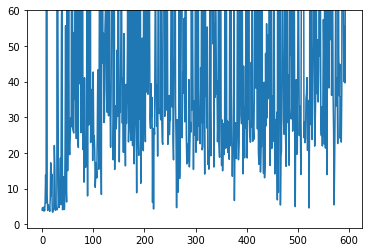

In [413]:
plt.plot(A_stats)
plt.ylim(-1, 60)

In [414]:
SPE_stats = np.mean(np.square(test_data - model(test_data).numpy()[:,:,-1]),axis=1)

(0.0, 0.5)

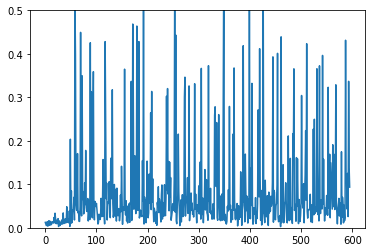

In [415]:
plt.plot(SPE_stats)
plt.ylim(0, 0.5)

In [416]:
Monitoring = A_stats/10+SPE_stats/0.1

In [417]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [418]:
prediction = 0.5-0.5*np.sign(Monitoring-1.3)
acc = accuracy_score(test_labels,prediction)
recall = recall_score(1-test_labels,1-prediction)
print('acc',acc)
print('recall',recall)

acc 0.9446308724832215
recall 0.9707495429616088


In [419]:
Result[N_train] = [acc,recall]

In [420]:
Result

{10: [0.8057090239410681, 0.926873857404022],
 21: [0.8, 0.9634369287020109],
 54: [0.8205374280230326, 0.9506398537477148],
 109: [0.8470111448834853, 0.9287020109689214],
 219: [0.8437856328392246, 0.9451553930530164],
 500: [0.9446308724832215, 0.9707495429616088]}